In [1]:
# %pip install tensorflow_addons

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import sys
sys.path.append("../") # /content/drive/MyDrive/HM-new/

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import gc

In [5]:
import tensorflow_addons as tfa

In [6]:
from src.data import DataHelper
from src.data.metrics import map_at_k

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [8]:
from pathlib import Path
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [10]:
# tf.compat.v1.disable_eager_execution()

In [11]:
RANK_EMBEDDING_DIM = 64
BATCH_SIZE = 2**12
NEPOCH = 20

In [12]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "pivot"

In [13]:
data_dir = Path("../data/") # /content/drive/MyDrive/HM-new
model_dir = Path("../models/") # /content/drive/MyDrive/HM-new

In [14]:
dh = DataHelper(data_dir)
data = dh.load_data(name="encoded_full")

In [15]:
inter = data['inter']
inter = inter.loc[(inter.t_dat <= "2020-08-19")]

## Calculate & Load Embeddings

In [16]:
# article description - TFIDF - SVD
if not os.path.exists(data_dir/'external/tfidf_item_embd.npy'):
    articles = pd.read_csv(data_dir/'raw/articles.csv')

    corpus = articles[[col for col in articles.columns if 'name' in col] + ['detail_desc']].T.apply(lambda x: ' '.join(map(str,x))).T

    vectorizer = TfidfVectorizer(min_df=3)
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=256, random_state=0)
    tfidf_item = svd.fit_transform(X)
    tfidf_item = np.concatenate([np.ones((1,256)), tfidf_item], axis=0)
    tfidf_item.dump(data_dir/'external/tfidf_item_embd.npy')
else:
    tfidf_item = np.load(data_dir/'external/tfidf_item_embd.npy', allow_pickle=True)

In [17]:
# article_id - customer_id TFIDF + SVD
if not os.path.exists(data_dir/'external/tfidf_item_embd2.npy'):
    corpus = inter.groupby('article_id').customer_id.apply(lambda x: ' '.join(map(str, x)))
    article_ids = np.array(list(corpus.index))

    vectorizer = TfidfVectorizer(min_df=3)
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=128, random_state=0)
    X_svd = svd.fit_transform(X)

    item_num = data['item']['article_id'].nunique()
    tfidf_item2 = np.ones((item_num+1, 128)) / 128
    for i,iid in enumerate(article_ids):
        tfidf_item2[iid,:] = X_svd[i,:]

    tfidf_item2.dump(data_dir/'external/tfidf_item_embd2.npy')
else:
    tfidf_item2 = np.load(data_dir/'external/tfidf_item_embd2.npy', allow_pickle=True)

In [18]:
# customer_id - product_code TFIDF + SVD
if not os.path.exists(data_dir/'external/tfidf_user_embd.npy'):
    inter = inter.merge(data['item'][['article_id','product_code']], on=['article_id'], how='left')
    corpus = inter.groupby('customer_id').product_code.apply(lambda x: ' '.join(map(str, x)))
    customer_ids = np.array(list(corpus.index))

    vectorizer = TfidfVectorizer(min_df=3)
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=128, random_state=0)
    X_svd = svd.fit_transform(X)

    user_num = data['user']['customer_id'].nunique()
    tfidf_user = np.ones((user_num+1, 128)) / 128
    for i,uid in enumerate(customer_ids):
        tfidf_user[uid,:] = X_svd[i,:]

    tfidf_user.dump(data_dir/'external/tfidf_user_embd.npy')
else:
    tfidf_user = np.load(data_dir/'external/tfidf_user_embd.npy', allow_pickle=True)

In [19]:
# * Load pre-trained embeddings
w2v_user_embd = np.load(data_dir/'external'/'w2v_user_embd.npy', allow_pickle=True)
w2v_item_embd = np.load(data_dir/'external'/'w2v_item_embd.npy', allow_pickle=True)
w2v_product_embd = np.load(data_dir/'external'/'w2v_product_embd.npy', allow_pickle=True)
image_item_embd = np.load(data_dir/'external'/'image_embd.npy', allow_pickle=True)
w2v_sg_user_embd = np.load(data_dir/'external'/'w2v_skipgram_user_embd.npy', allow_pickle=True)
w2v_sg_item_embd = np.load(data_dir/'external'/'w2v_skipgram_item_embd.npy', allow_pickle=True)
w2v_sg_product_embd = np.load(data_dir/'external'/'w2v_skipgram_product_embd.npy', allow_pickle=True)

## Load Candidates & Prepare Data

In [20]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")    

100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


In [21]:
# feats = [
#     x
#     for x in candidates[1].columns
#     if x
#     not in [
#         "label",
#         "sales_channel_id",
#         "t_dat",
#         "week",
#     ]
# ]
feats = [
    "customer_id",
    "article_id",
    "ItemPairRetrieve_1",
    "ItemPairRetrieve_2",
    "ItemPairRetrieve_3",
    "ItemPairRetrieve_4",
    "OrderHistoryDecay_1",
    "OrderHistoryDecay_2",
    "OrderHistory_1",
    "OrderHistory_2",
    "SaleTrend_1",
    "TimeHistoryDecay_1",
    "TimeHistoryDecay_2",
    "TimeHistory_1",
    "TimeHistory_2",
    "UGSaleTrend_1",
    "UGTimeHistory_1",
    "UGTimeHistory_2",
    "price",
    "product_code",
    "i_repurchase_ratio",
    "p_repurchase_ratio",
    "i_sale",
    "p_sale",
    "i_sale_uni",
    "p_sale_uni",
    "lw_i_sale",
    "lw_p_sale",
    "lw_i_sale_uni",
    "lw_p_sale_uni",
    "i_sale_ratio",
    "i_sale_uni_ratio",
    "lw_i_sale_ratio",
    "lw_i_sale_uni_ratio",
    "i_uni_ratio",
    "p_uni_ratio",
    "lw_i_uni_ratio",
    "lw_p_uni_ratio",
    "i_sale_trend",
    "p_sale_trend",
    "product_type_no_sale",
    "lw_product_type_no_sale",
    "product_type_no_sale_trend",
    "product_group_name_sale",
    "lw_product_group_name_sale",
    "product_group_name_sale_trend",
    "graphical_appearance_no_sale",
    "lw_graphical_appearance_no_sale",
    "graphical_appearance_no_sale_trend",
    "colour_group_code_sale",
    "lw_colour_group_code_sale",
    "colour_group_code_sale_trend",
    "perceived_colour_value_id_sale",
    "lw_perceived_colour_value_id_sale",
    "perceived_colour_value_id_sale_trend",
    "perceived_colour_master_id_sale",
    "lw_perceived_colour_master_id_sale",
    "perceived_colour_master_id_sale_trend",
    "i_1w_sale_rank",
    "i_1w_sale_norm",
    "p_1w_sale_rank",
    "p_1w_sale_norm",
    "i_2w_sale",
    "i_2w_sale_rank",
    "i_2w_sale_norm",
    "p_2w_sale",
    "p_2w_sale_rank",
    "p_2w_sale_norm",
    "i_3w_sale",
    "i_3w_sale_rank",
    "i_3w_sale_norm",
    "p_3w_sale",
    "p_3w_sale_rank",
    "p_3w_sale_norm",
    "i_4w_sale",
    "i_4w_sale_rank",
    "i_4w_sale_norm",
    "p_4w_sale",
    "p_4w_sale_rank",
    "p_4w_sale_norm",
    "i_pop",
    "p_pop",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "user_gender",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
    "article_gender",
    "season_type",
    "dssm_similarity",
    "yt_similarity",
]
cat_features = [
    # "product_type_no",
    # "product_group_name",
    # "graphical_appearance_no",
    # "colour_group_code",
    # "perceived_colour_value_id",
    # "perceived_colour_master_id",
    # "FN",
    # "Active",
    # "club_member_status",
    # "fashion_news_frequency",
    # "user_gender",
    # "article_gender",
    # "season_type",
    # "age",
]
ids = ["customer_id", "article_id", "product_code"]
dense_feats = [x for x in feats if x not in cat_features + ids]

In [22]:
full_data = pd.concat([candidates[i] for i in range(1,WEEK_NUM)], ignore_index=True)
train = full_data[full_data['week']>1]
valid = full_data[full_data['week']==1]

In [23]:
del candidates
gc.collect()

20

In [24]:
# Normalize
# for feat in dense_feats:
    # mask = train[feat].notnull()
    # value = train.loc[mask, feat].mean()
    # train[feat] = train[feat].fillna(value)
    # valid[feat] = valid[feat].fillna(value)
    # scaler = MinMaxScaler().fit(train[feat].values.reshape(-1,1))
    # train[feat] = scaler.transform(train[feat].values.reshape(-1,1))
    # valid[feat] = scaler.transform(valid[feat].values.reshape(-1,1))

In [25]:
feat_dim = {}
for feat in cat_features + ids:
    if feat in data['user'].columns:
        feat_dim[feat] = int(data['user'][feat].max()) + 1
    elif feat in data['item'].columns:
        feat_dim[feat] = int(data['item'][feat].max()) + 1
    else:
        feat_dim[feat] = int(full_data[feat].max()) + 1

In [26]:
del full_data
gc.collect()

20

In [27]:
X_train1 = train[['customer_id', 'article_id', 'product_code']].values.astype('int32')
X_train2 = np.zeros((X_train1.shape[0], len(feats[3:])), dtype='float32')
for i,f in tqdm(enumerate(feats[3:])):
    X_train2[:, i] = np.nan_to_num(train[f].values).astype('float32')
    del train[f]
y_train = train['label'].values

95it [00:11,  7.99it/s]


In [28]:
X_test1 = valid[['customer_id', 'article_id', 'product_code']].values.astype('int32')
X_test2 = np.zeros((X_test1.shape[0], len(feats[3:])), dtype='float32')
for i,f in tqdm(enumerate(feats[3:])):
    X_test2[:, i] = np.nan_to_num(valid[f].values).astype('float32')
    del valid[f]
y_test = valid['label'].values

95it [00:03, 25.48it/s]


## Train Model

In [29]:
customer_embd_layer_1 = Embedding(
    feat_dim["customer_id"], 64, weights=[w2v_sg_user_embd], trainable=False
)
customer_embd_layer_2 = Embedding(
    feat_dim["customer_id"], 64, weights=[w2v_user_embd], trainable=False
)
customer_embd_layer_3 = Embedding(
    feat_dim["customer_id"], 128, weights=[tfidf_user], trainable=False
)

In [30]:
article_embd_layer_1 = Embedding(
    feat_dim["article_id"], 64, weights=[w2v_sg_item_embd], trainable=False
)

article_embd_layer_2 = Embedding(
    feat_dim["article_id"], 64, weights=[w2v_item_embd], trainable=False
)

article_embd_layer_3 = Embedding(
    feat_dim["article_id"], 256, weights=[tfidf_item], trainable=False
)

article_embd_layer_4 = Embedding(
    feat_dim["article_id"], 128, weights=[tfidf_item2], trainable=False
)

article_embd_layer_5 = Embedding(
    feat_dim["article_id"], 512, weights=[image_item_embd], trainable=False
)

In [31]:
product_embd_layer_1 = Embedding(
    feat_dim["product_code"], 64, weights=[w2v_sg_product_embd], trainable=False
)
product_embd_layer_2 = Embedding(
    feat_dim["product_code"], 64, weights=[w2v_product_embd], trainable=False
)

In [32]:
inputs1 = Input(shape=X_train1.shape[1:], dtype=tf.int64)
inputs2 = Input(shape=X_train2.shape[1:], dtype=tf.float32)
input1 = tf.cast(inputs1, dtype=tf.int64)

x_c_id1 = customer_embd_layer_1(input1[:,0])
x_c_id2 = customer_embd_layer_2(input1[:,0])
x_c_id3 = customer_embd_layer_3(input1[:,0])

x_a_id1 = article_embd_layer_1(input1[:,1])
x_a_id2 = article_embd_layer_2(input1[:,1])
x_a_id3 = article_embd_layer_3(input1[:,1])
x_a_id3 = Dense(128)(x_a_id3)
x_a_id4 = article_embd_layer_4(input1[:,1])
x_a_id5 = article_embd_layer_5(input1[:,1])
x_a_id5 = Dense(128)(x_a_id5)

x_p_id1 = product_embd_layer_1(input1[:,2])
x_p_id2 = product_embd_layer_2(input1[:,2])


x_id = Concatenate(axis=-1)([
    x_c_id1, x_c_id2,
    x_a_id1, x_a_id2, x_a_id3, x_a_id4, x_a_id5,
    x_p_id1, x_p_id2,
])

x0 = Concatenate(axis=-1)([x_id, BatchNormalization()(inputs2)])
x = Dropout(0.2)(x0)
x = Dense(512, activation='swish')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='swish')(x)

x = Concatenate(axis=-1)([x, x0])
x = Dropout(0.2)(x)

output = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=[output])
model.summary()
    
model.compile(
    tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss = 'binary_crossentropy',
    metrics=['AUC']
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 3)            0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None,)              0           tf.cast[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None,)              0           tf.cast[0][0]                    
______________________________________________________________________________________________

In [35]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_dir/'model_nn.h5',
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

history = model.fit(
    [X_train1, X_train2], y_train.astype(int), 
    shuffle=True,
    batch_size=2048,
    validation_data=([X_test1, X_test2], y_test.astype(int)),
    epochs=30,
    callbacks=[checkpoint, early_stop]
)
# 0.7114
# 0.7294
# 0.7382
# 0.7565

Epoch 1/30
4769/4769 [==============================] - 45s 9ms/step - loss: 0.0378 - auc: 0.7034 - val_loss: 0.3501 - val_auc: 0.5389
Epoch 2/30
4769/4769 [==============================] - 42s 9ms/step - loss: 0.0368 - auc: 0.7294 - val_loss: 0.0792 - val_auc: 0.6252
Epoch 3/30
4769/4769 [==============================] - 42s 9ms/step - loss: 0.0367 - auc: 0.7348 - val_loss: 0.0416 - val_auc: 0.6670
Epoch 4/30
4769/4769 [==============================] - 41s 9ms/step - loss: 0.0366 - auc: 0.7383 - val_loss: 0.0423 - val_auc: 0.6828
Epoch 5/30
4769/4769 [==============================] - 42s 9ms/step - loss: 0.0366 - auc: 0.7398 - val_loss: 0.0505 - val_auc: 0.7140
Epoch 6/30
4769/4769 [==============================] - 41s 9ms/step - loss: 0.0366 - auc: 0.7403 - val_loss: 0.0421 - val_auc: 0.7314
Epoch 7/30
4769/4769 [==============================] - 35s 7ms/step - loss: 0.0365 - auc: 0.7403 - val_loss: 0.0548 - val_auc: 0.7125
Epoch 8/30
4769/4769 [==============================] -

In [31]:
model.load_weights(model_dir/'model_nn.h5')

In [32]:
probs = model.predict([X_test1, X_test2], batch_size=4096)

In [33]:
label = data['inter'][data['inter']['t_dat']>='2020-09-16']
label = label.groupby('customer_id')['article_id'].apply(list).reset_index()

In [34]:
valid['prob'] = probs
pred = valid.sort_values(by='prob',ascending=False).reset_index(drop=True)
pred = pred.groupby('customer_id')['article_id'].apply(list).reset_index()
pred.columns = ['customer_id','prediction']

In [35]:
label = label.merge(pred, on='customer_id', how='left')

In [36]:
label.head()

,customer_id,article_id,prediction
0,81,[28968],"[42130, 74, 67523, 104046, 44033, 71108, 94657..."
1,87,[87372],"[100229, 27906, 98607, 104074, 103584, 33869, ..."
2,108,"[69712, 77257, 33873]","[13043, 61304, 2220, 61306, 61305, 53894, 5389..."
3,118,[97392],"[103794, 3092, 104073, 56695, 67523, 81554, 94..."
4,180,"[102398, 98410, 74, 95785, 103797, 105104, 103...","[105181, 95217, 104987, 104073, 103794, 95218,..."


In [37]:
map_at_k(label['article_id'], label['prediction'], k=12)
# 0.028500554033301987
# 0.029904528760153

# 0.031648009478868075
# 0.031309369857160076

# 0.03178218657727387

0.03167130018296487

In [38]:
valid = valid[['customer_id','article_id','prob']]
valid.to_csv(data_dir/'external'/'nn_valid.csv', index=None)

## Test

In [33]:
del train, valid, X_train1, X_train2, X_test1, X_test2
gc.collect()

285

In [34]:
model.load_weights(model_dir/'model_nn.h5')

In [35]:
test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/"week0_candidate.pqt")

In [36]:
test1 = test_candidates[['customer_id', 'article_id', 'product_code']].values.astype('int32')

In [37]:
test2 = np.zeros((test1.shape[0], len(feats[3:])), dtype='float32')
for i,f in tqdm(enumerate(feats[3:])):
    test2[:, i] = np.nan_to_num(test_candidates[f].values).astype('float32')
    del test_candidates[f]

95it [04:12,  2.66s/it]


In [38]:
class TQDMPredictCallback(tf.keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

In [40]:
probs = model.predict([test1, test2], batch_size=2048, callbacks=[TQDMPredictCallback()])

100%|██████████| 27007/27007 [10:50<00:00, 41.53it/s]


In [42]:
test_candidates['prob'] = probs

In [43]:
pred_nn = test_candidates[['customer_id','article_id','prob']]
pred_nn.to_csv(data_dir/"processed"/"nn_test.csv", index=False)

<AxesSubplot:>

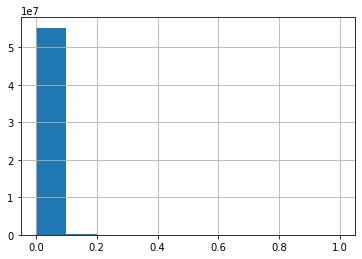

In [44]:
pred_nn['prob'].hist()